# Autothermal Reformer Flowsheet Optimization with ALAMO Surrogate Object

## 1. Introduction

This example demonstrates autothermal reformer optimization leveraging the ALAMO surrogate trainer and IDAES Python wrapper. In this notebook, sampled simulation data will be used to train and validate a surrogate model. IDAES surrogate plotting tools will be utilized to visualize the surrogates on training and validation data. Once validated, integration of the surrogate into an IDAES flowsheet will be demonstrated.

# 2. Problem Statement 

Within the context of a larger NGFC system, the autothermal reformer generates syngas from air, steam and natural gas for use in a solid-oxide fuel cell (SOFC).

## 2.1. Main Inputs: 
- Bypass fraction (dimensionless) - split fraction of natural gas to bypass AR unit and feed directly to the power island
- NG-Steam Ratio (dimensionless) - proportion of natural relative to steam fed into AR unit operation

## 2.2. Main Outputs:
- Steam flowrate (kg/s) - inlet steam fed to AR unit
- Reformer duty (kW) - required energy input to AR unit
- Composition (dimensionless) - outlet mole fractions of components (Ar, C2H6, C3H8, C4H10, CH4, CO, CO2, H2, H2O, N2, O2)

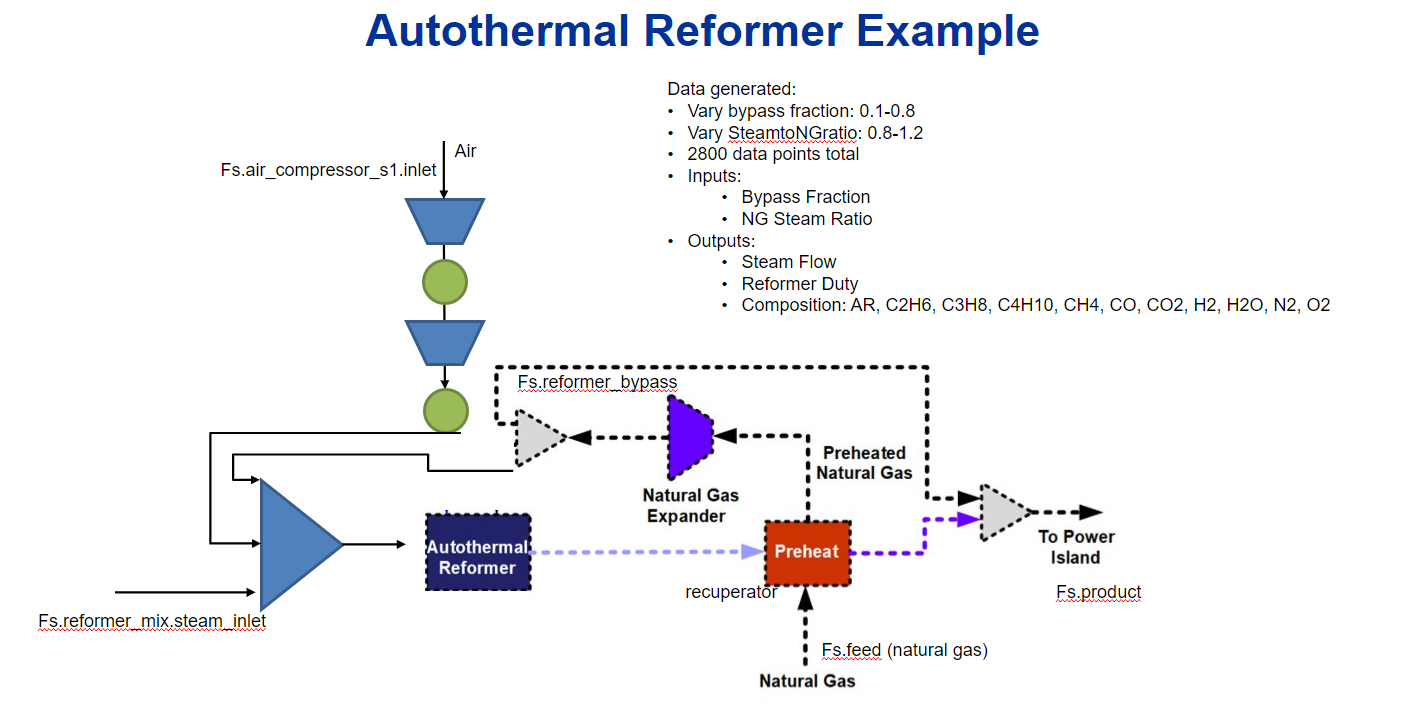

In [1]:
from IPython.display import Image
Image("AR_PFD.png")

## 3. Training and Validating Surrogates

First, let's import the required Python, Pyomo and IDAES modules:

In [2]:
# Import statements
import os
import numpy as np
import pandas as pd

# Import Pyomo libraries
from pyomo.environ import ConcreteModel, SolverFactory, value, Var, \
    Constraint, Set, Objective, maximize
from pyomo.common.timing import TicTocTimer

# Import IDAES libraries
from idaes.core.surrogate.sampling.data_utils import split_training_validation
from idaes.core.surrogate.alamopy import AlamoTrainer, AlamoSurrogate
from idaes.core.surrogate.plotting.sm_plotter import surrogate_scatter2D, surrogate_parity, surrogate_residual
from idaes.core.surrogate.surrogate_block import SurrogateBlock
from idaes.core import FlowsheetBlock
from idaes.core.util.convergence.convergence_base import _run_ipopt_with_stats

## 3.1 Importing Training and Validation Datasets

In this section, we read the dataset from the CSV file located in this directory. 2800 data points were simulated from a rigorous IDAES NGFC flowsheet using a grid sampling method. For simplicity and to reduce training runtime, this example randomly selects 100 data points to use for training/validation. The data is separated using an 80/20 split into training and validation data using the IDAES `split_training_validation()` method.

In [3]:
# Import Auto-reformer training data
np.set_printoptions(precision=6, suppress=True)

csv_data = pd.read_csv(r'reformer-data.csv') # 2800 data points
data = csv_data.sample(n = 100) # randomly sample points for training/validation

input_data = data.iloc[:, :2]
output_data = data.iloc[:, 2:]

# Define labels, and split training and validation data
input_labels = input_data.columns
output_labels = output_data.columns

n_data = data[input_labels[0]].size
data_training, data_validation = split_training_validation(data, 0.8, seed=n_data)  # seed=100

## 3.2 Training Surrogates with ALAMO

IDAES provides a Python wrapper for the ALAMO machine learning tool via an imported AlamoTrainer class. Regression settings can be directly set as config attributes, as shown below. In this example, allowed basis term forms include constant and linear functions, monomial power order 2 and 3, variable product power order 1 and 2, and variable ratio power order 1 and 2. ALAMO naturally seeks to minimize the number of basis terms; here, we restrict each surrogate expression to a maximum of 10 basis terms.

Finally, after training the model we save the results and model expressions to a JSON file. Serializing the model in this fashion enables importing a previously trained set of surrogate models into external flowsheets. This feature will be used later.

In [4]:
# capture long output (not required to use surrogate API)
from io import StringIO
import sys
stream = StringIO()
oldstdout = sys.stdout
sys.stdout = stream

# Create ALAMO trainer object
trainer = AlamoTrainer(input_labels=input_labels,
                       output_labels=output_labels,
                       training_dataframe=data_training)

# Set ALAMO options
trainer.config.constant = True
trainer.config.linfcns = True
trainer.config.multi2power = [1, 2]
trainer.config.monomialpower = [2, 3]
trainer.config.ratiopower = [1, 2]
trainer.config.maxterms = [10] * len(output_labels)  # max for each surrogate
trainer.config.filename = os.path.join(os.getcwd(), 'alamo_run.alm')
trainer.config.overwrite_files = True

# Train surrogate (calls ALAMO through IDAES ALAMOPy wrapper)
success, alm_surr, msg = trainer.train_surrogate()

# save model to JSON
model = alm_surr.save_to_file('alamo_surrogate.json', overwrite=True)

# create callable surrogate object

surrogate_expressions = trainer._results['Model']
input_labels = trainer._input_labels
output_labels = trainer._output_labels
xmin, xmax = [0.1, 0.8], [0.8, 1.2]
input_bounds = {input_labels[i]: (xmin[i], xmax[i])
                for i in range(len(input_labels))}

alm_surr = AlamoSurrogate(surrogate_expressions,
                          input_labels,
                          output_labels,
                          input_bounds)

# revert back to normal output capture
sys.stdout = oldstdout

# display first 50 lines and last 50 lines of output
celloutput = stream.getvalue().split('\n')
for line in celloutput[:50]:
    print(line)
print('.')
print('.')
print('.')
for line in celloutput[-50:]:
    print(line)

 ***************************************************************************
 ALAMO version 2022.6.4. Built: WIN-64 Sat Jun 4 21:18:44 EDT 2022 

 If you use this software, please cite:
 Cozad, A., N. V. Sahinidis and D. C. Miller,
 Automatic Learning of Algebraic Models for Optimization,
 AIChE Journal, 60, 2211-2227, 2014.

 ALAMO is powered by the BARON software from http://www.minlp.com/
 ***************************************************************************
 Licensee: Brandon Paul at US Department of Energy, brandon.paul@netl.doe.gov.
 ***************************************************************************
 Reading input data
 Checking input consistency and initializing data structures
 
 Step 0: Initializing data set
 User provided an initial data set of 80 data points
 We will sample no more data points at this stage
 ***************************************************************************
 Iteration 1 (Approx. elapsed time 0.47E-01 s)
 
 Step 1: Model building using

## 3.3 Visualizing surrogates

Now that the surrogate models have been trained, the models can be visualized through scatter, parity and residual plots to confirm their validity in the chosen domain. The training data will be visualized first to confirm the surrogates are fit the data, and then the validation data will be visualized to confirm the surrogates accurately predict new output values.

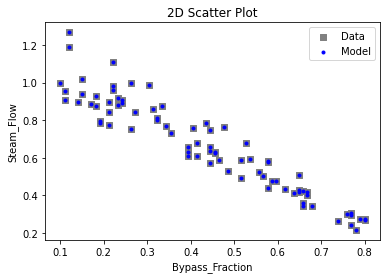

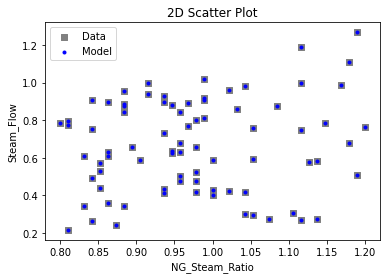

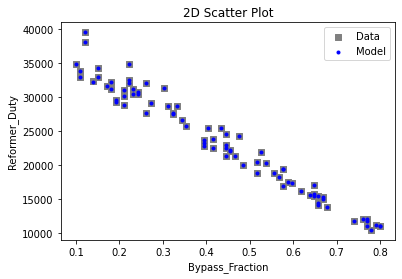

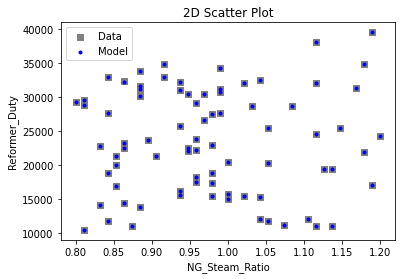

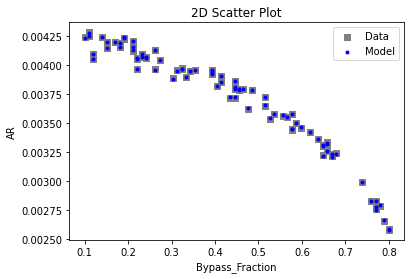

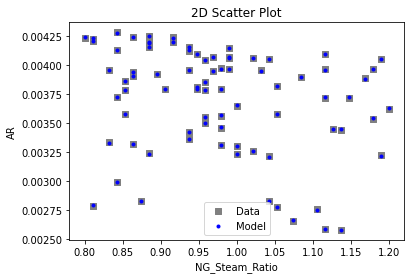

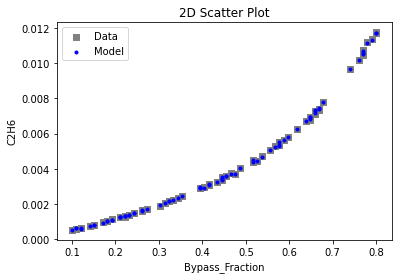

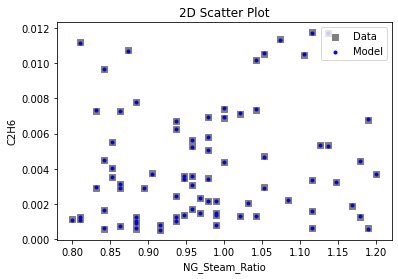

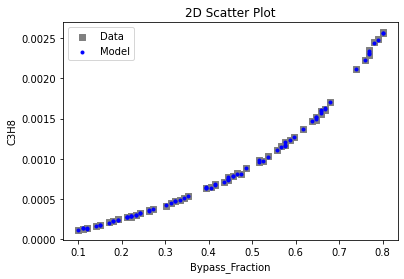

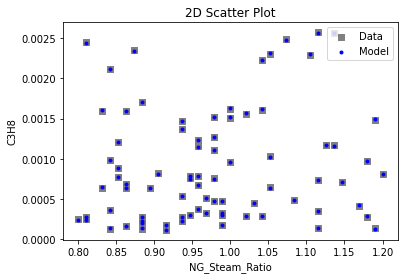

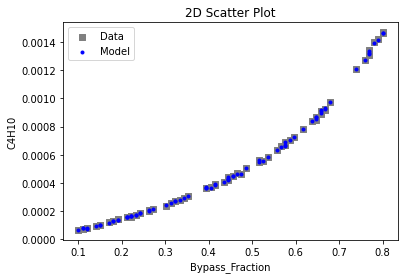

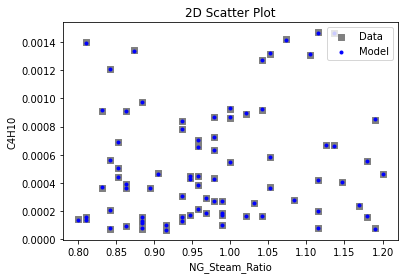

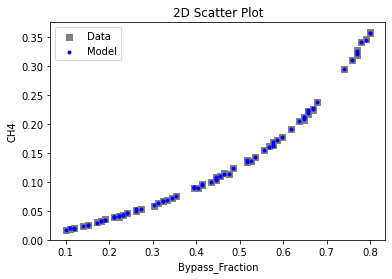

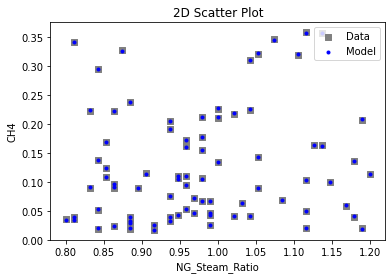

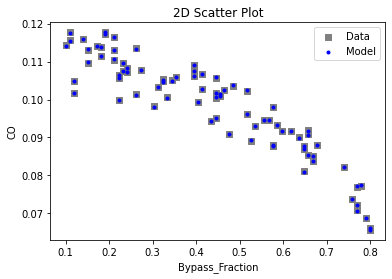

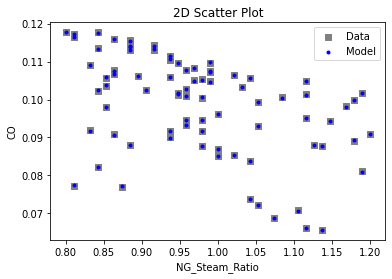

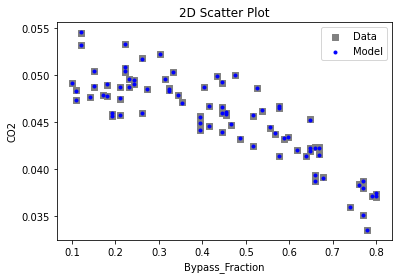

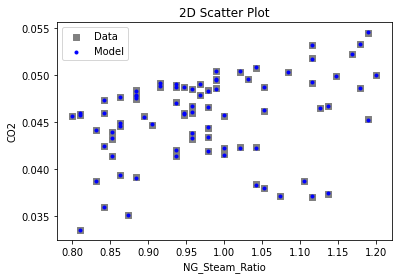

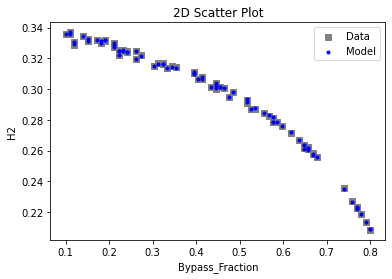

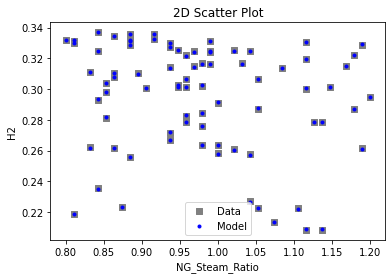

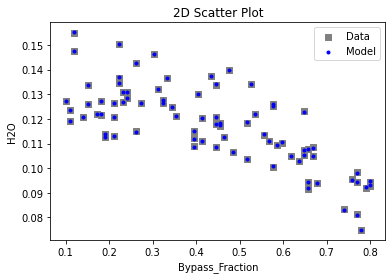

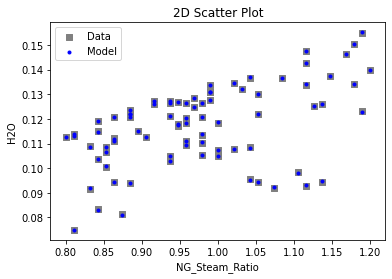

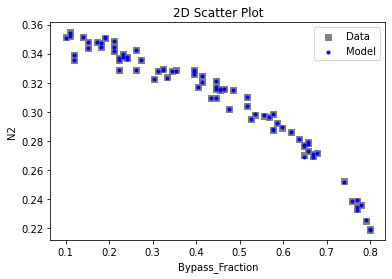

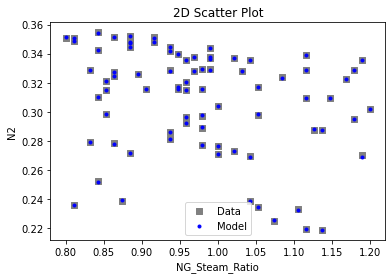

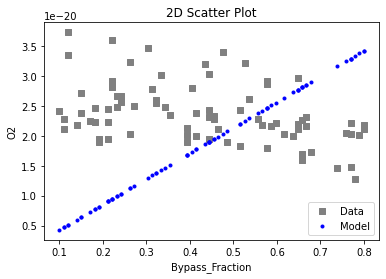

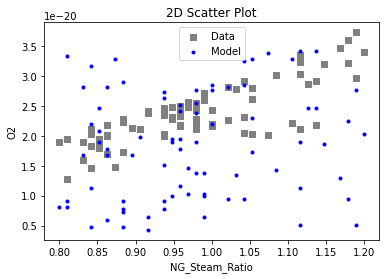

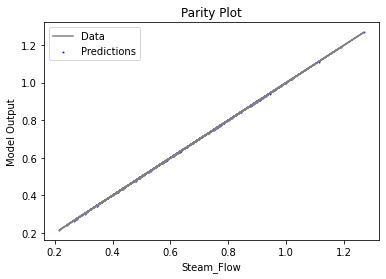

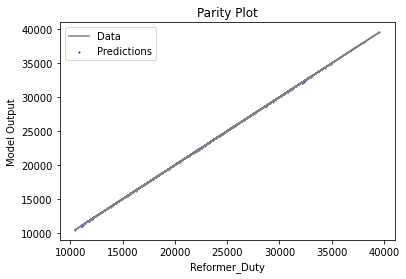

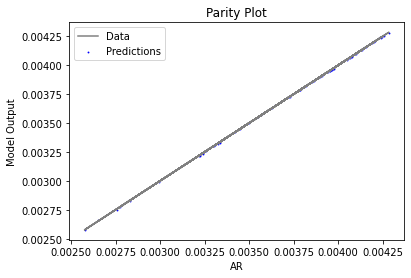

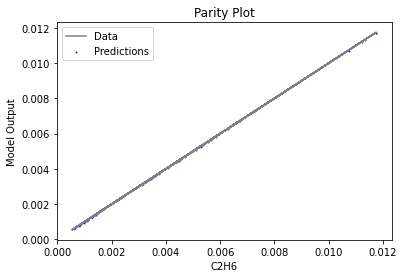

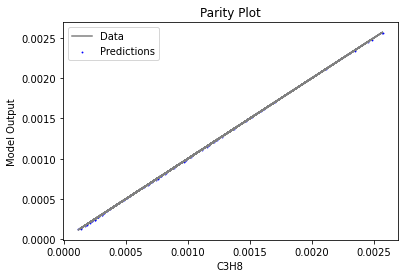

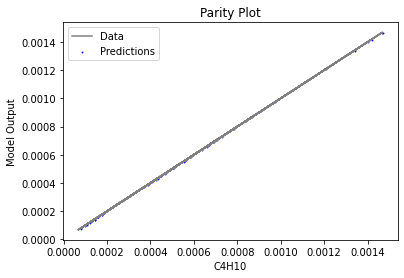

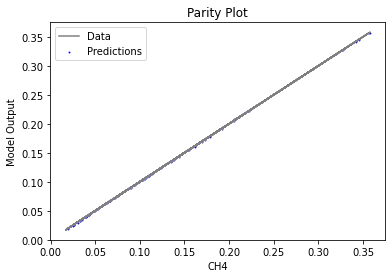

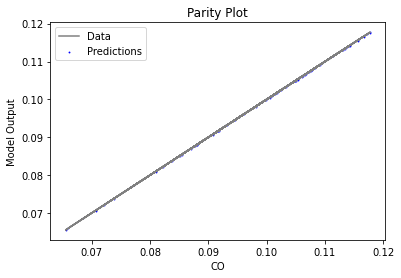

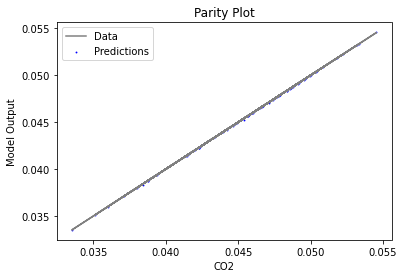

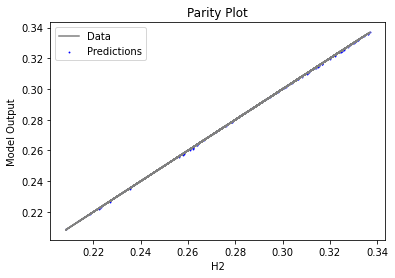

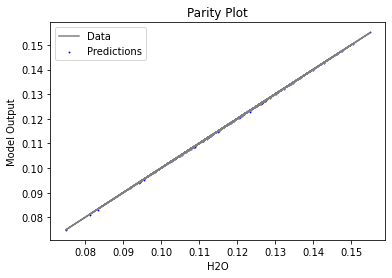

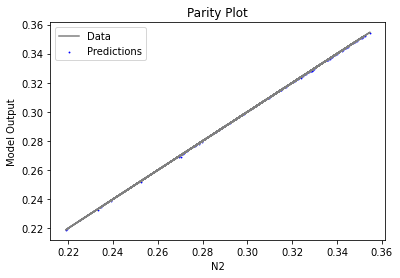

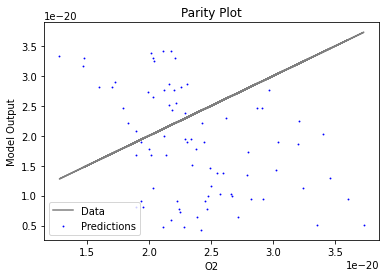

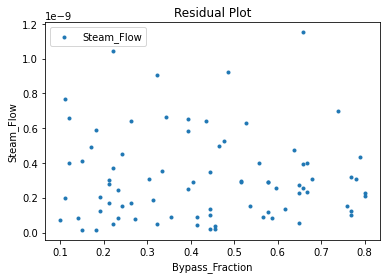

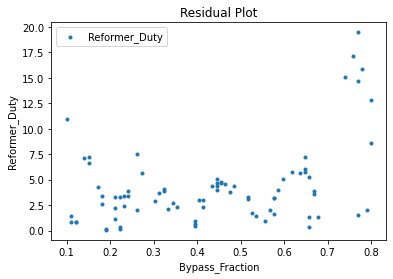

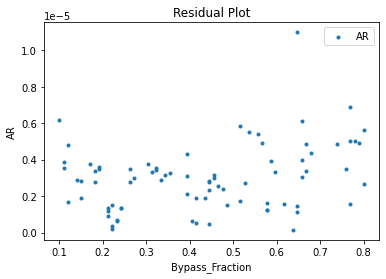

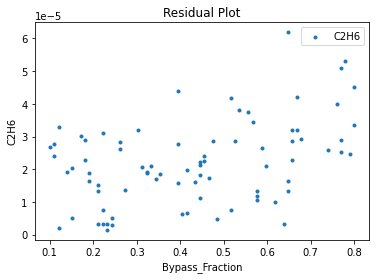

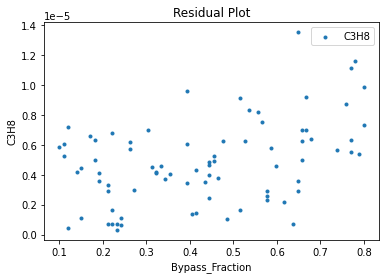

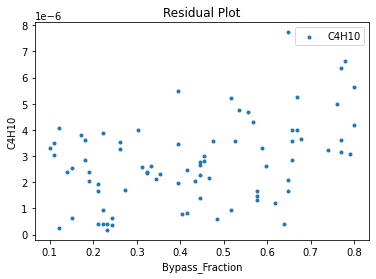

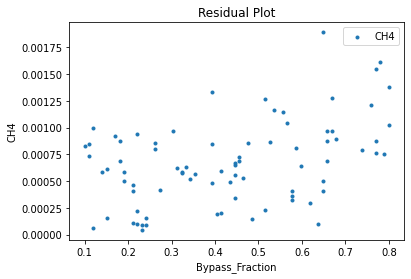

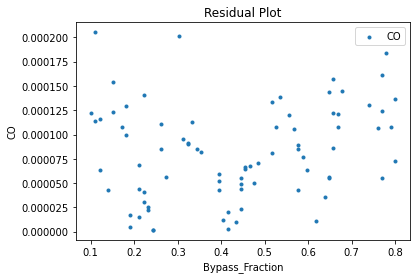

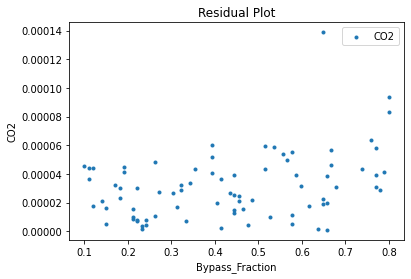

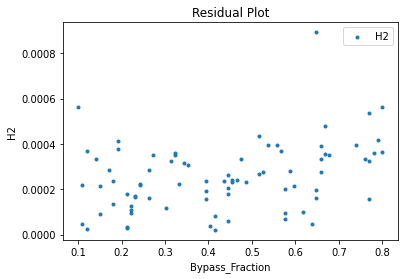

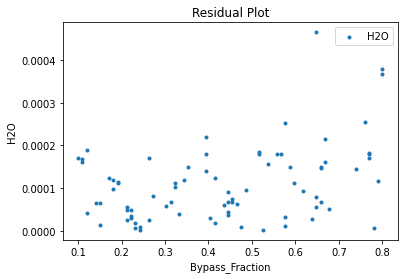

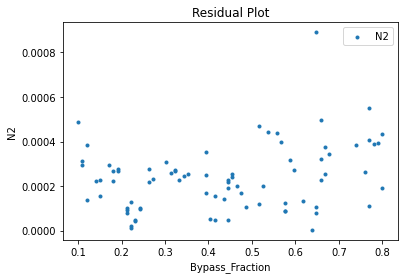

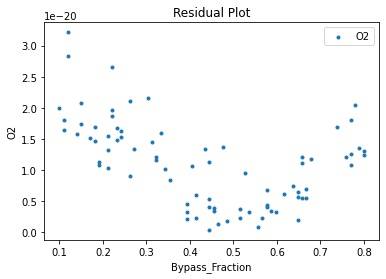

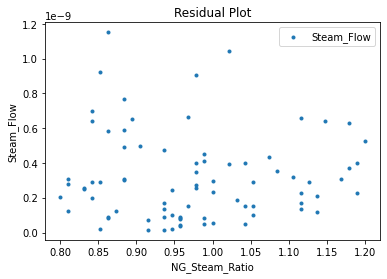

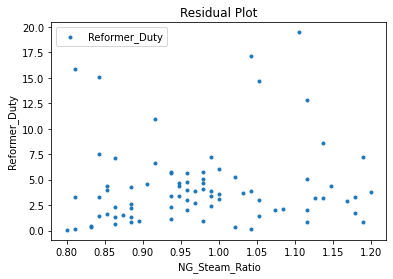

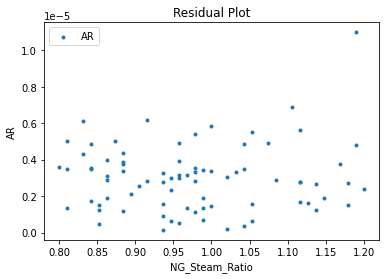

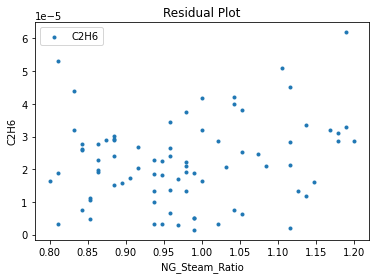

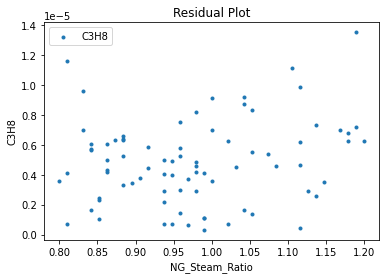

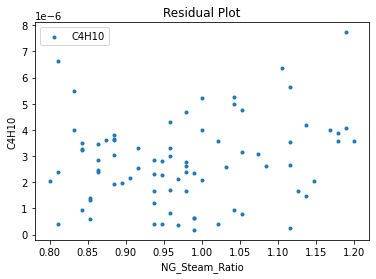

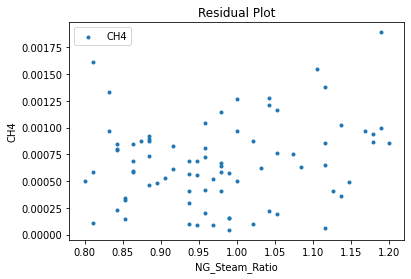

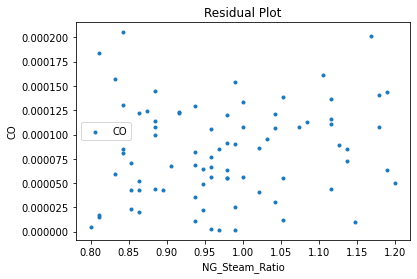

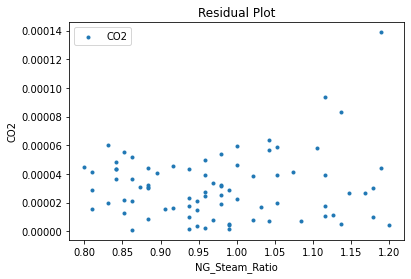

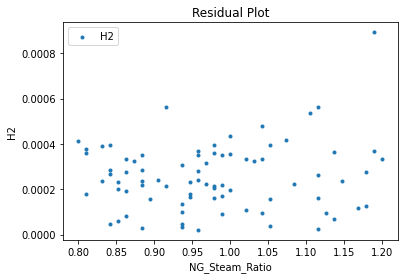

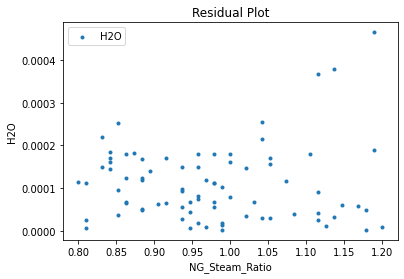

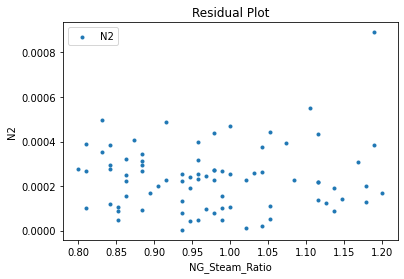

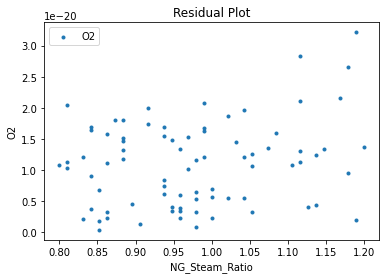

In [5]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(alm_surr, data_training, filename='alamo_train_scatter2D.pdf')
surrogate_parity(alm_surr, data_training, filename='alamo_train_parity.pdf')
surrogate_residual(alm_surr, data_training, filename='alamo_train_residual.pdf')

## 3.4 Model Validation

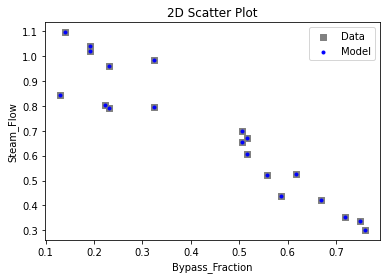

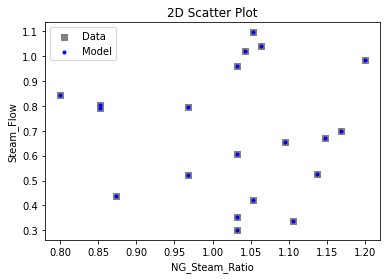

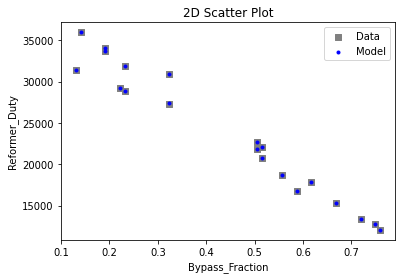

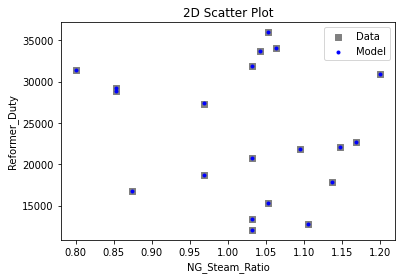

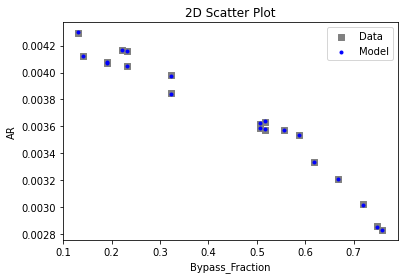

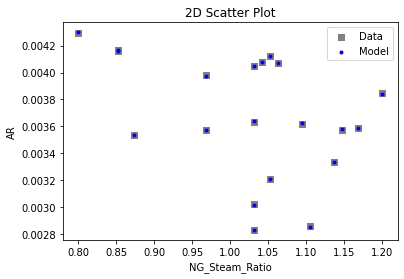

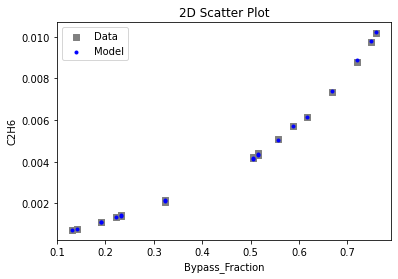

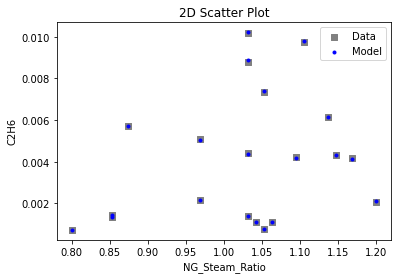

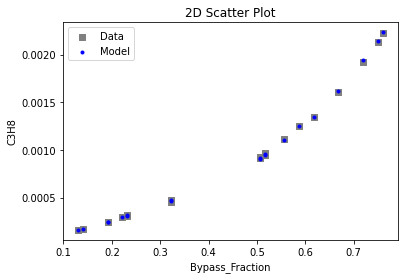

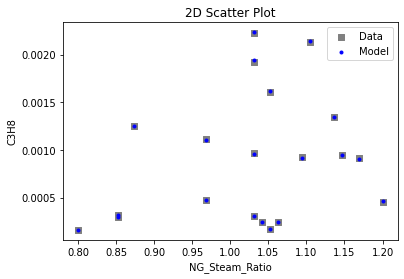

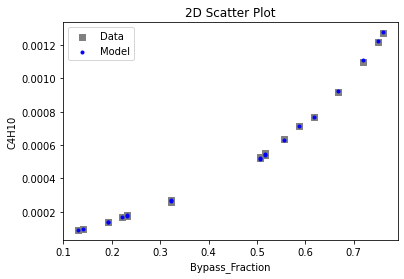

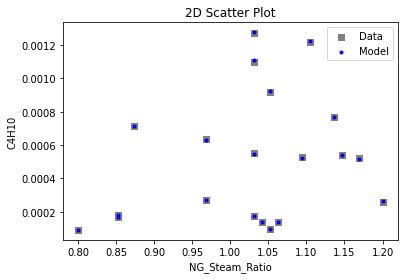

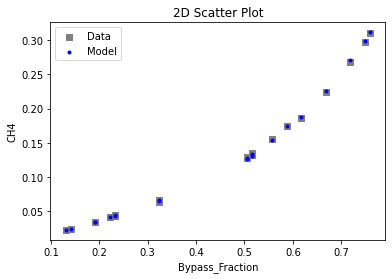

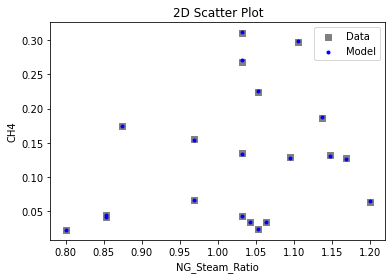

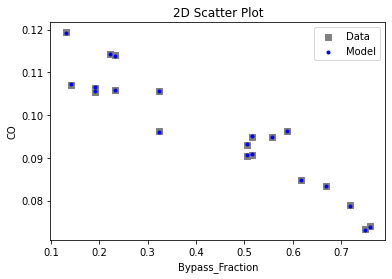

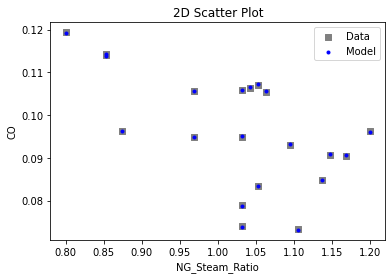

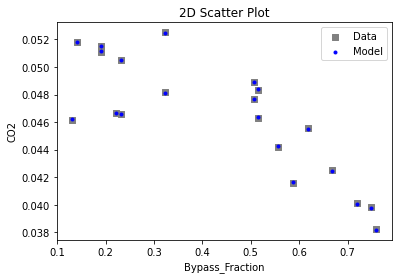

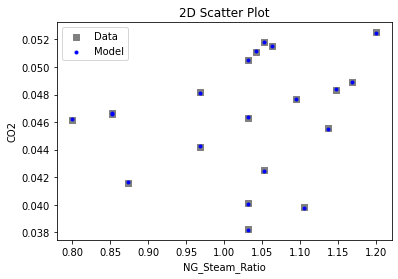

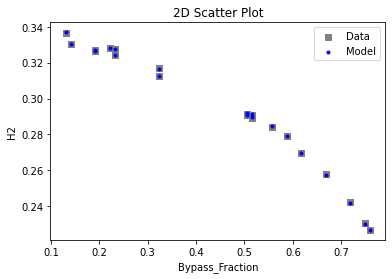

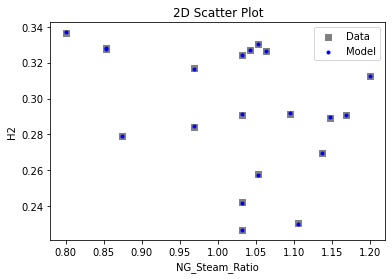

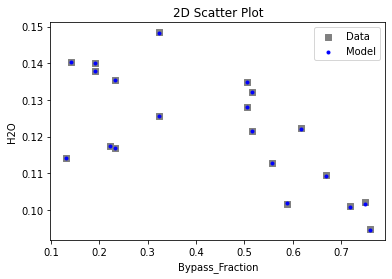

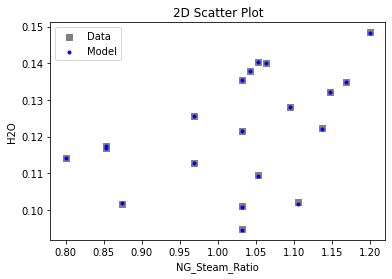

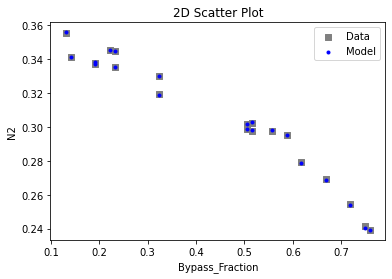

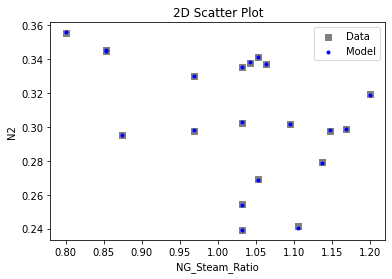

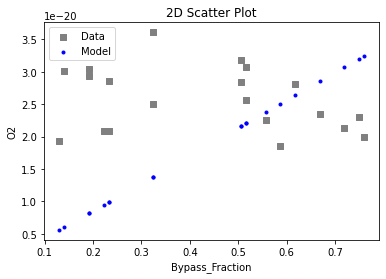

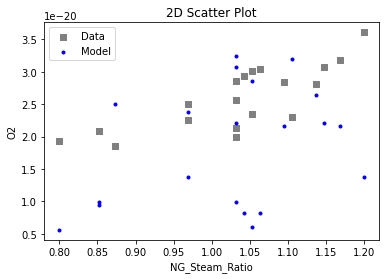

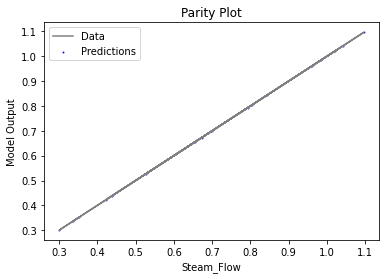

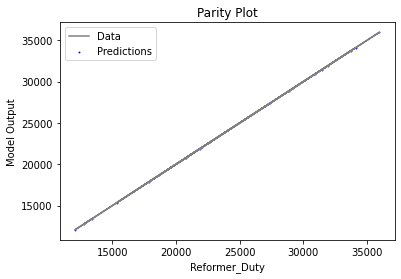

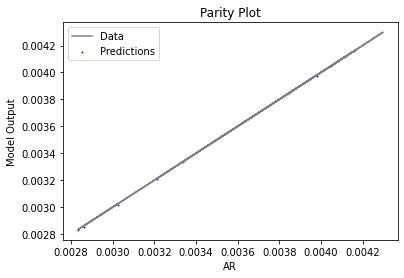

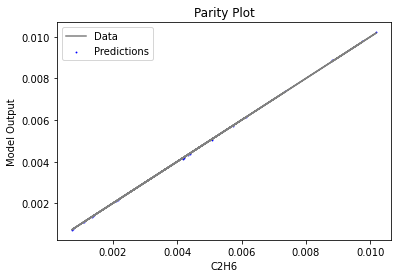

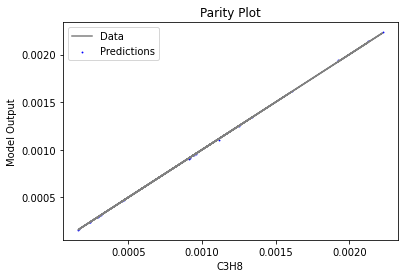

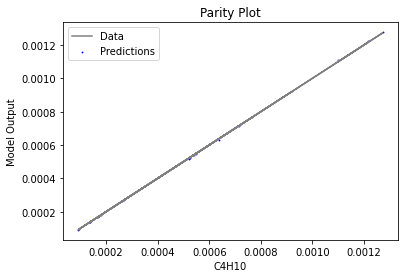

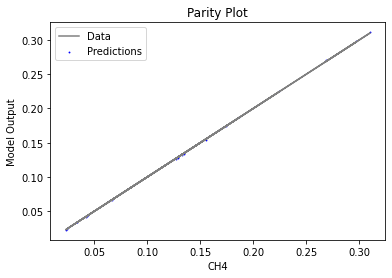

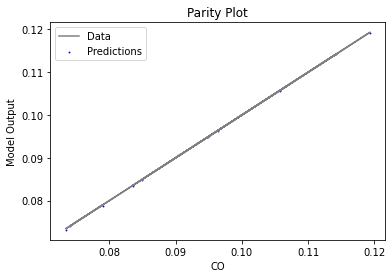

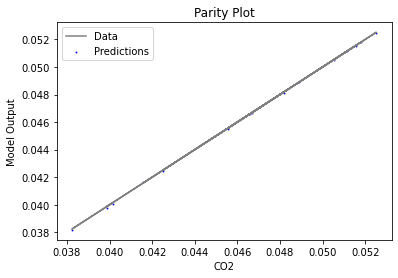

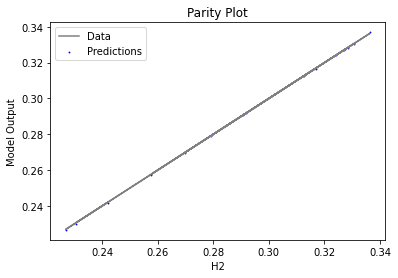

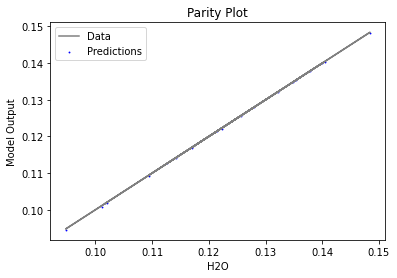

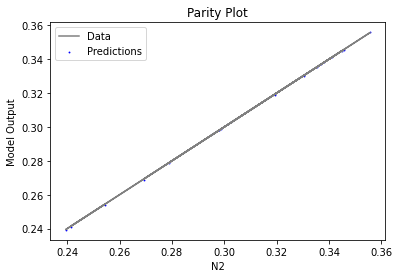

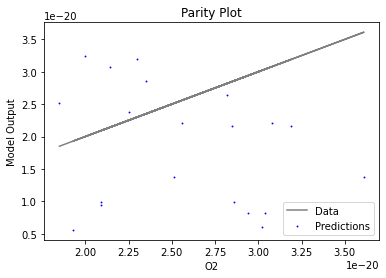

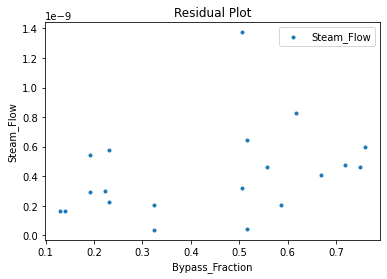

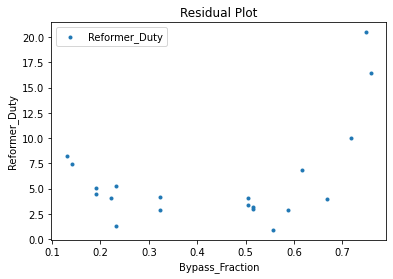

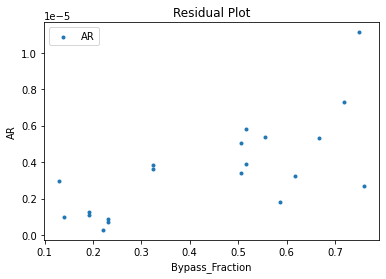

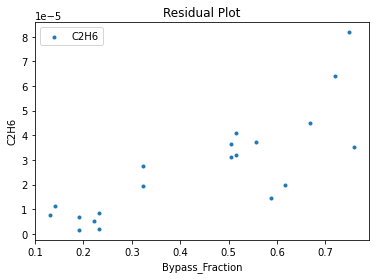

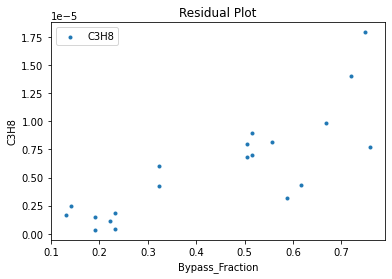

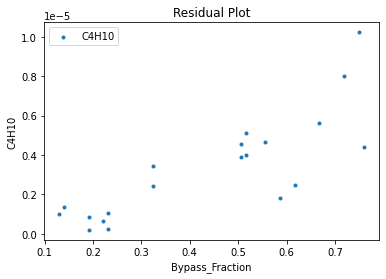

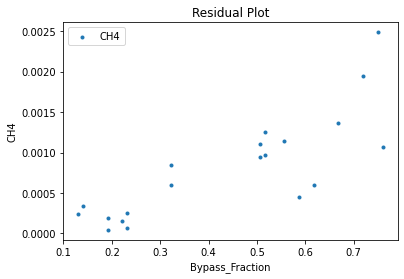

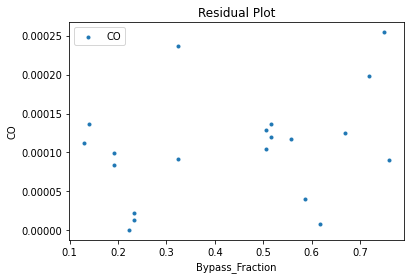

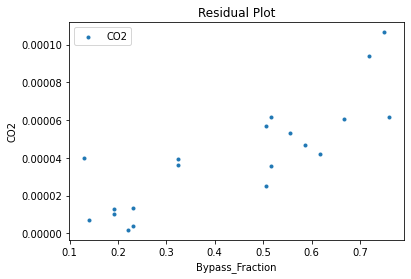

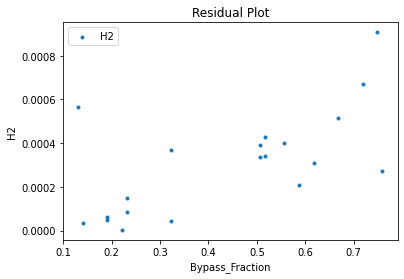

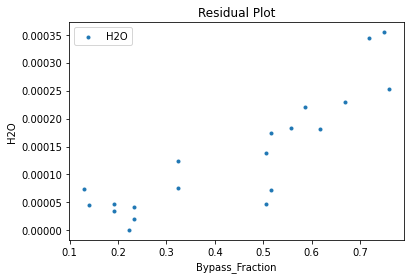

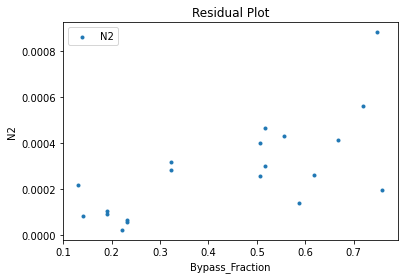

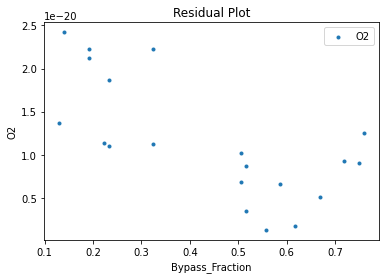

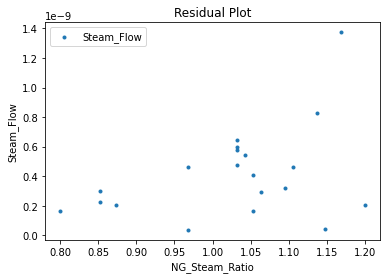

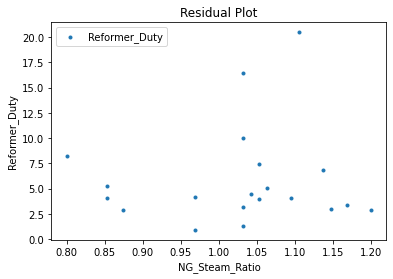

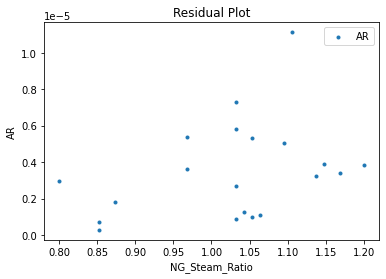

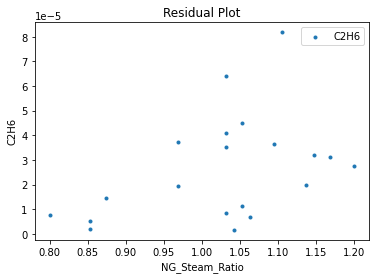

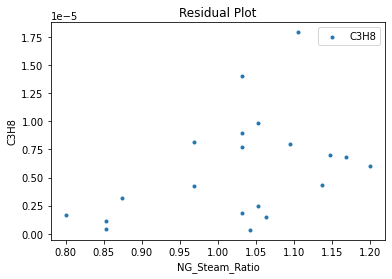

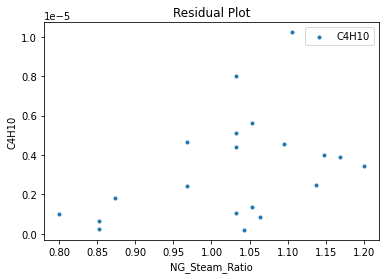

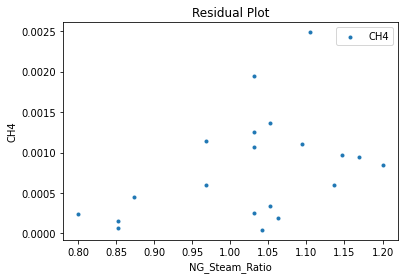

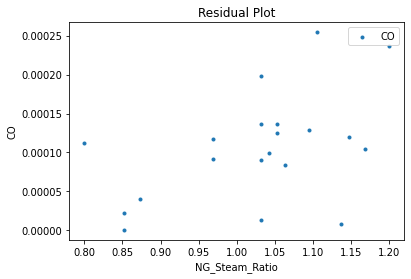

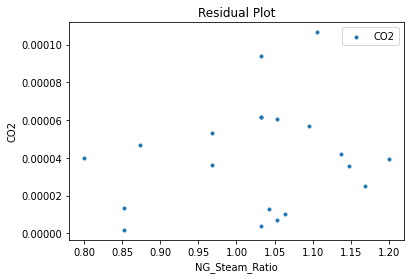

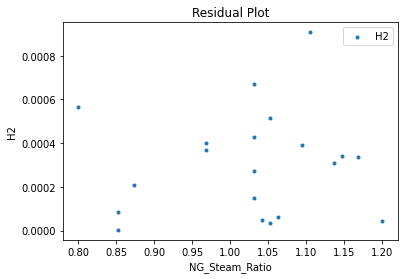

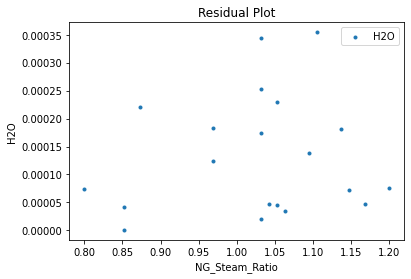

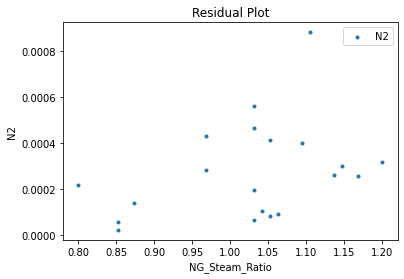

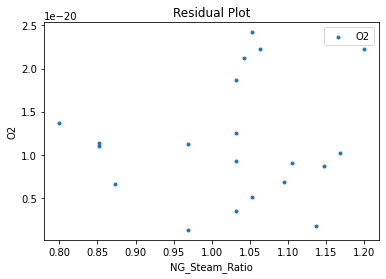

In [6]:
# visualize with IDAES surrogate plotting tools
surrogate_scatter2D(alm_surr, data_validation, filename='alamo_val_scatter2D.pdf')
surrogate_parity(alm_surr, data_validation, filename='alamo_val_parity.pdf')
surrogate_residual(alm_surr, data_validation, filename='alamo_val_residual.pdf')

# 4. IDAES Flowsheet Integration

## 4.1 Build and Run IDAES Flowsheet

Next, we will build an IDAES flowsheet and import the surrogate model object. A single ALAMO model accounts for all input and output variables, and the JSON model serialized earlier may be imported into a single SurrogateBlock() component.

In [7]:
# create the IDAES model and flowsheet
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

# create flowsheet input variables
m.fs.bypass_frac = Var(initialize=0.80, bounds=[0.1, 0.8], doc='natural gas bypass fraction')
m.fs.ng_steam_ratio = Var(initialize=0.80, bounds=[0.8, 1.2], doc='natural gas to steam ratio')

# create flowsheet output variables
m.fs.steam_flowrate = Var(initialize=0.2, doc="steam flowrate")
m.fs.reformer_duty = Var(initialize=10000, doc="reformer heat duty")
m.fs.AR = Var(initialize=0, doc="AR fraction")
m.fs.C2H6 = Var(initialize=0, doc="C2H6 fraction")
m.fs.C3H8 = Var(initialize=0, doc="C3H8 fraction")
m.fs.C4H10 = Var(initialize=0, doc="C4H10 fraction")
m.fs.CH4 = Var(initialize=0, doc="CH4 fraction")
m.fs.CO = Var(initialize=0, doc="CO fraction")
m.fs.CO2 = Var(initialize=0, doc="CO2 fraction")
m.fs.H2 = Var(initialize=0, doc="H2 fraction")
m.fs.H2O = Var(initialize=0, doc="H2O fraction")
m.fs.N2 = Var(initialize=0, doc="N2 fraction")
m.fs.O2 = Var(initialize=0, doc="O2 fraction")

# create input and output variable object lists for flowsheet
inputs = [m.fs.bypass_frac, m.fs.ng_steam_ratio]
outputs = [m.fs.steam_flowrate, m.fs.reformer_duty, m.fs.AR, m.fs.C2H6, m.fs.C4H10,
           m.fs.C3H8, m.fs.CH4, m.fs.CO, m.fs.CO2, m.fs.H2, m.fs.H2O, m.fs.N2, m.fs.O2]

# create the Pyomo/IDAES block that corresponds to the surrogate
# ALAMO
surrogate = AlamoSurrogate.load_from_file('alamo_surrogate.json')
m.fs.surrogate = SurrogateBlock()
m.fs.surrogate.build_model(surrogate, input_vars=inputs, output_vars=outputs)

# fix input values and solve flowsheet
m.fs.bypass_frac.fix(0.5)
m.fs.ng_steam_ratio.fix(1)

solver = SolverFactory('ipopt')
[status_obj, solved, iters, time] = _run_ipopt_with_stats(m, solver)

Setting bound of fs.bypass_frac to (0.1, 0.8).
Setting bound of fs.ng_steam_ratio to (0.8, 1.2).
Ipopt 3.13.2: output_file=C:\Users\BRANDO~1\AppData\Local\Temp\tmp2_ucmvc5ipopt_out
max_iter=500
max_cpu_time=120


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material re

Let's print some model results:

In [8]:
print("Model status: ", status_obj)
print("Solution optimal: ", solved)
print("IPOPT iterations: ", iters)
print("IPOPT runtime: ", time)

print()
print("Steam flowrate = ", value(m.fs.steam_flowrate))
print("Reformer duty = ", value(m.fs.reformer_duty))
print("Mole Fraction Ar = ", value(m.fs.AR))
print("Mole Fraction C2H6 = ", value(m.fs.C2H6))
print("Mole Fraction C3H8 = ", value(m.fs.C3H8))
print("Mole Fraction C4H10 = ", value(m.fs.C4H10))
print("Mole Fraction CH4 = ", value(m.fs.CH4))
print("Mole Fraction CO = ", value(m.fs.CO))
print("Mole Fraction CO2 = ", value(m.fs.CO2))
print("Mole Fraction H2 = ", value(m.fs.H2))
print("Mole Fraction H2O = ", value(m.fs.H2O))
print("Mole Fraction N2 = ", value(m.fs.N2))
print("Mole Fraction O2 = ", value(m.fs.O2))

Model status:  
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 13
  Number of variables: 13
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.13.2\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.2094426155090332
Solution: 
- number of solutions: 0
  number of solutions displayed: 0

Solution optimal:  True
IPOPT iterations:  1
IPOPT runtime:  0.003

Steam flowrate =  0.6059308500747188
Reformer duty =  21068.896454790138
Mole Fraction Ar =  0.0036846678610474716
Mole Fraction C2H6 =  0.004146872011449644
Mole Fraction C3H8 =  0.0005183595236673216
Mole Fraction C4H10 =  0.0009071282080405121
Mole Fraction CH4 =  0.1266287998484575
Mole Fraction CO =  0.0970758772284375
Mole Fraction CO2 =  0.0460869646000556
Mole Fraction H2 =  0.2942813308018739
Mole Fraction H2O =  0.11974769512891137
Mole Fraction N2 =  0.3068670405677719
Mole Fraction O2 =  2.1384562649052595e-20


## 4.2 Optimizing the Autothermal Reformer
Extending this example, we will unfix the input variables and optimize hydrogen production. We will restrict nitrogen below 34 mol% of the product stream and leave all other variables unfixed.

Above, variable values are called in reference to actual objects names; however, as shown below this may be done much more compactly by calling the list objects we created earlier.

In [9]:
# unfix input values and add the objective/constraint to the model
m.fs.bypass_frac.unfix()
m.fs.ng_steam_ratio.unfix()
m.fs.obj = Objective(expr=m.fs.H2, sense=maximize)
m.fs.con = Constraint(expr=m.fs.N2 <= 0.34)

# solve the model
tmr = TicTocTimer()
status = solver.solve(m, tee=True)
solve_time = tmr.toc('solve')

# print and check results
assert abs(value(m.fs.H2)-0.33) <= 0.01
assert value(m.fs.N2 <= 0.4+1e-8)
print('Model status: ', status)
print('Solve time: ', solve_time)
for var in inputs:
    print(var.name,': ', value(var))
for var in outputs:
    print(var.name,': ', value(var))

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://